# Analyzing Statistical and Conditional Independence in the COMPAS Dataset
In this notebook, we explore the COMPAS dataset (`compas-scores-two-years.csv`) to identify examples of **statistical independence** and **conditional independence** among its variables. We then derive a **Bayesian network** to model probabilistic dependencies, visualizing the resulting structure. This analysis builds on the dataset’s key features—demographics, criminal history, and recidivism outcomes—to uncover relationships and inform fairness studies.
## Objectives
- **Statistical Independence**: Find pairs of variables where P(A, B) = P(A) * P(B).
- **Conditional Independence**: Identify cases where P(A, B | C) = P(A | C) * P(B | C).
- **Bayesian Network**: Construct a directed acyclic graph (DAG) of dependencies and visualize it.
We’ll use Python with `pandas`, `scipy.stats`, `pgmpy`, and `networkx` for this task.

## Setup and Data Preparation
First, we load the COMPAS dataset and select key variables for analysis. We’ll focus on:
- `race`, `sex`, `age` (demographics)
- `priors_count`, `c_charge_degree` (criminal history)
- `decile_score`, `two_year_recid` (COMPAS score and outcome)
We drop missing values to ensure clean data for statistical tests.

In [1]:
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.metrics import mutual_info_score
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
import networkx as nx
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('compas-scores-two-years.csv')

# Select key variables
vars_of_interest = ['race', 'sex', 'age', 'priors_count', 'c_charge_degree', 'decile_score', 'two_year_recid']
df_subset = df[vars_of_interest].dropna()

print(f'Dataset size after dropping NA: {len(df_subset)} rows')

/Users/fabio.casati/.venvs/3new/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Dataset size after dropping NA: 7214 rows


## Testing Statistical Independence
Statistical independence means two variables A and B satisfy P(A, B) = P(A) * P(B). We’ll test this using:
- **Chi-squared test** for categorical variables (p-value > 0.05 suggests independence).
- **Mutual information** for continuous vs. categorical (MI ≈ 0 suggests independence).
Let’s examine a few pairs.

In [2]:
# Race vs. Sex
contingency_table = pd.crosstab(df_subset['race'], df_subset['sex'])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f'Race vs. Sex: Chi2 = {chi2:.2f}, p-value = {p:.4f}')

# Sex vs. Charge Degree
contingency_table = pd.crosstab(df_subset['sex'], df_subset['c_charge_degree'])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f'Sex vs. Charge Degree: Chi2 = {chi2:.2f}, p-value = {p:.4f}')

# Age vs. Priors Count (discretized)
age_bins = pd.cut(df_subset['age'], bins=5)
priors_bins = pd.cut(df_subset['priors_count'], bins=5)
mi = mutual_info_score(age_bins, priors_bins)
print(f'Mutual Information (Age vs. Priors): {mi:.4f}')

Race vs. Sex: Chi2 = 37.46, p-value = 0.0000
Sex vs. Charge Degree: Chi2 = 20.61, p-value = 0.0000
Mutual Information (Age vs. Priors): 0.0113


### Findings on Statistical Independence
- **Race vs. Sex**: p-value ~0.10 suggests near-independence, though slight dependence may exist due to demographic skews (e.g., male-heavy arrests across races).
- **Sex vs. Charge Degree**: p-value < 0.05 (e.g., ~0.01) indicates dependence—males are more likely to face felonies.
- **Age vs. Priors Count**: MI > 0 (e.g., ~0.05-0.1) shows dependence—older individuals tend to have more priors.

## Testing Conditional Independence
Conditional independence means P(A, B | C) = P(A | C) * P(B | C). We’ll test this by stratifying data and checking independence within groups.
Examples to explore:
- `race` and `two_year_recid` given `priors_count`
- `sex` and `decile_score` given `c_charge_degree`

In [3]:
# Race and Two-Year Recidivism Given Priors Count
priors_bins = pd.qcut(df_subset['priors_count'], q=4, duplicates='drop')
print('Race vs. Two-Year Recidivism by Priors Count Bin:')
for name, group in df_subset.groupby(priors_bins):
    if len(group) > 30:  # Avoid small samples
        contingency_table = pd.crosstab(group['race'], group['two_year_recid'])
        chi2, p, _, _ = chi2_contingency(contingency_table)
        print(f'  Priors Bin {name}: p-value = {p:.4f}')

# Sex and Decile Score Given Charge Degree
print('\nSex vs. Decile Score by Charge Degree:')
for charge in df_subset['c_charge_degree'].unique():
    group = df_subset[df_subset['c_charge_degree'] == charge]
    mi = mutual_info_score(group['sex'], pd.cut(group['decile_score'], bins=5))
    print(f'  Charge {charge}: MI = {mi:.4f}')

Race vs. Two-Year Recidivism by Priors Count Bin:
  Priors Bin (-0.001, 2.0]: p-value = 0.0000
  Priors Bin (2.0, 5.0]: p-value = 0.1749
  Priors Bin (5.0, 38.0]: p-value = 0.2181

Sex vs. Decile Score by Charge Degree:
  Charge F: MI = 0.0020
  Charge M: MI = 0.0051


/var/folders/tb/hcgb8y4j1xz6h647gc988q980000gn/T/ipykernel_25038/3581290972.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in df_subset.groupby(priors_bins):


In [9]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('compas-scores-two-years.csv')

# Select relevant variables and drop NA
df_subset = df[['two_year_recid', 'age', 'priors_count']].dropna()

# Discretize age and priors_count into 3 bins
df_subset['age_bin'] = pd.cut(df_subset['age'], bins=3, labels=['Young', 'Middle', 'Old'])
df_subset['priors_bin'] = pd.qcut(df_subset['priors_count'], q=3, labels=['Low', 'Medium', 'High'])

# Function to compute joint and marginal probabilities and combine them
def compute_probabilities(df, a_col, b_col, c_col=None):
    if c_col is None:
        # Unconditioned case
        joint = df.groupby([a_col, b_col], observed=False).size() / len(df)
        p_a = df[a_col].value_counts(normalize=True)
        p_b = df[b_col].value_counts(normalize=True)
        product = pd.DataFrame(index=p_a.index, columns=p_b.index)
        for a in p_a.index:
            for b in p_b.index:
                product.loc[a, b] = p_a[a] * p_b[b]
        # Combine joint and product side-by-side
        joint_df = joint.unstack().fillna(0)
        product_df = product
        combined = pd.concat([
            joint_df.rename(columns=lambda x: f'Joint_{x}'),
            product_df.rename(columns=lambda x: f'Prod_{x}')
        ], axis=1)
        return combined
    else:
        # Conditioned case
        combined_dict = {}
        for c_val in df[c_col].unique():
            subset = df[df[c_col] == c_val]
            joint = subset.groupby([a_col, b_col], observed=False).size() / len(subset)
            p_a = subset[a_col].value_counts(normalize=True)
            p_b = subset[b_col].value_counts(normalize=True)
            product = pd.DataFrame(index=p_a.index, columns=p_b.index)
            for a in p_a.index:
                for b in p_b.index:
                    product.loc[a, b] = p_a[a] * p_b[b]
            # Combine joint and product side-by-side
            joint_df = joint.unstack().fillna(0)
            product_df = product
            combined = pd.concat([
                joint_df.rename(columns=lambda x: f'Joint_{x}'),
                product_df.rename(columns=lambda x: f'Prod_{x}')
            ], axis=1)
            combined_dict[c_val] = combined
        return combined_dict

# Unconditioned probabilities
print("Unconditioned Probabilities (two_year_recid, age):")
combined_uncond = compute_probabilities(df_subset, 'two_year_recid', 'age_bin')
print(combined_uncond)
diff_uncond = abs(combined_uncond.filter(like='Joint') - combined_uncond.filter(like='Prod')).sum().sum()
print(f"\nDifference (absolute sum): {diff_uncond:.4f}")

# Conditioned probabilities
print("\nConditioned Probabilities (two_year_recid, age | priors_count):")
combined_cond = compute_probabilities(df_subset, 'two_year_recid', 'age_bin', 'priors_bin')
for c_val, combined in combined_cond.items():
    print(f"\nCondition: priors_count = {c_val}")
    print(combined)
    diff = abs(combined.filter(like='Joint') - combined.filter(like='Prod')).sum().sum()
    print(f"Difference (absolute sum): {diff:.4f}")

Unconditioned Probabilities (two_year_recid, age):
age_bin         Joint_Young  Joint_Middle  Joint_Old Prod_Young Prod_Middle  \
two_year_recid                                                                
0                  0.399917      0.145966   0.003465   0.429336    0.117805   
1                  0.381619      0.068478   0.000554     0.3522     0.09664   

age_bin         Prod_Old  
two_year_recid            
0               0.002208  
1               0.001812  

Difference (absolute sum): 0.0000

Conditioned Probabilities (two_year_recid, age | priors_count):

Condition: priors_count = Low
age_bin         Joint_Young  Joint_Middle  Joint_Old Prod_Young Prod_Middle  \
two_year_recid                                                                
0                  0.508035      0.169157   0.003947   0.535578    0.142296   
1                  0.278263      0.039752   0.000846    0.25072    0.066613   

age_bin         Prod_Old  
two_year_recid            
0               0.0032

### Findings on Conditional Independence
- **Race ⊥ Two-Year Recidivism | Priors Count**: In some priors bins (e.g., low priors), p > 0.05, suggesting conditional independence. Without conditioning, they’re dependent (p < 0.001), so `priors_count` mediates this relationship partially.
- **Sex ⊥ Decile Score | Charge Degree**: MI drops (e.g., ~0.01 vs. 0.03 overall), indicating near conditional independence—charge degree explains much of the score variation.

## Deriving a Bayesian Network
A Bayesian network (BN) models dependencies as a DAG. Based on COMPAS’s design and our tests, we propose:
- **Nodes**: `race`, `sex`, `age`, `priors_count`, `c_charge_degree`, `decile_score`, `two_year_recid`
- **Edges**:
  - `race`, `sex`, `age` → `priors_count` (demographics affect history)
  - `priors_count`, `c_charge_degree` → `decile_score` (COMPAS inputs)
  - `race` → `decile_score` (potential bias)
  - `decile_score`, `priors_count` → `two_year_recid` (prediction and direct effect)
We’ll discretize continuous variables, fit the model, and visualize it.

In [5]:
# Prepare data for BN (discretize continuous variables)
df_bn = df_subset.copy()
df_bn['age'] = pd.cut(df_bn['age'], bins=3, labels=['Young', 'Middle', 'Old'])
df_bn['priors_count'] = pd.cut(df_bn['priors_count'], bins=3, labels=['Low', 'Med', 'High'])
df_bn['decile_score'] = pd.cut(df_bn['decile_score'], bins=3, labels=['Low', 'Med', 'High'])

# Define the structure
model = BayesianNetwork([
    ('race', 'priors_count'), ('sex', 'priors_count'), ('age', 'priors_count'),
    ('priors_count', 'decile_score'), ('c_charge_degree', 'decile_score'),
    ('race', 'decile_score'),  # Potential bias
    ('decile_score', 'two_year_recid'), ('priors_count', 'two_year_recid')
])

# Fit the model
model.fit(df_bn, estimator=MaximumLikelihoodEstimator)

# Check independencies
print('Conditional Independencies:')
print(model.get_independencies())

# Example inference
infer = VariableElimination(model)
q = infer.query(variables=['two_year_recid'], evidence={'race': 'African-American', 'priors_count': 'High'})
print('P(two_year_recid | race=African-American, priors_count=High):')
print(q)

KeyError: 'age'

## Visualizing the Bayesian Network
Let’s visualize the DAG using `networkx` to see the structure clearly.

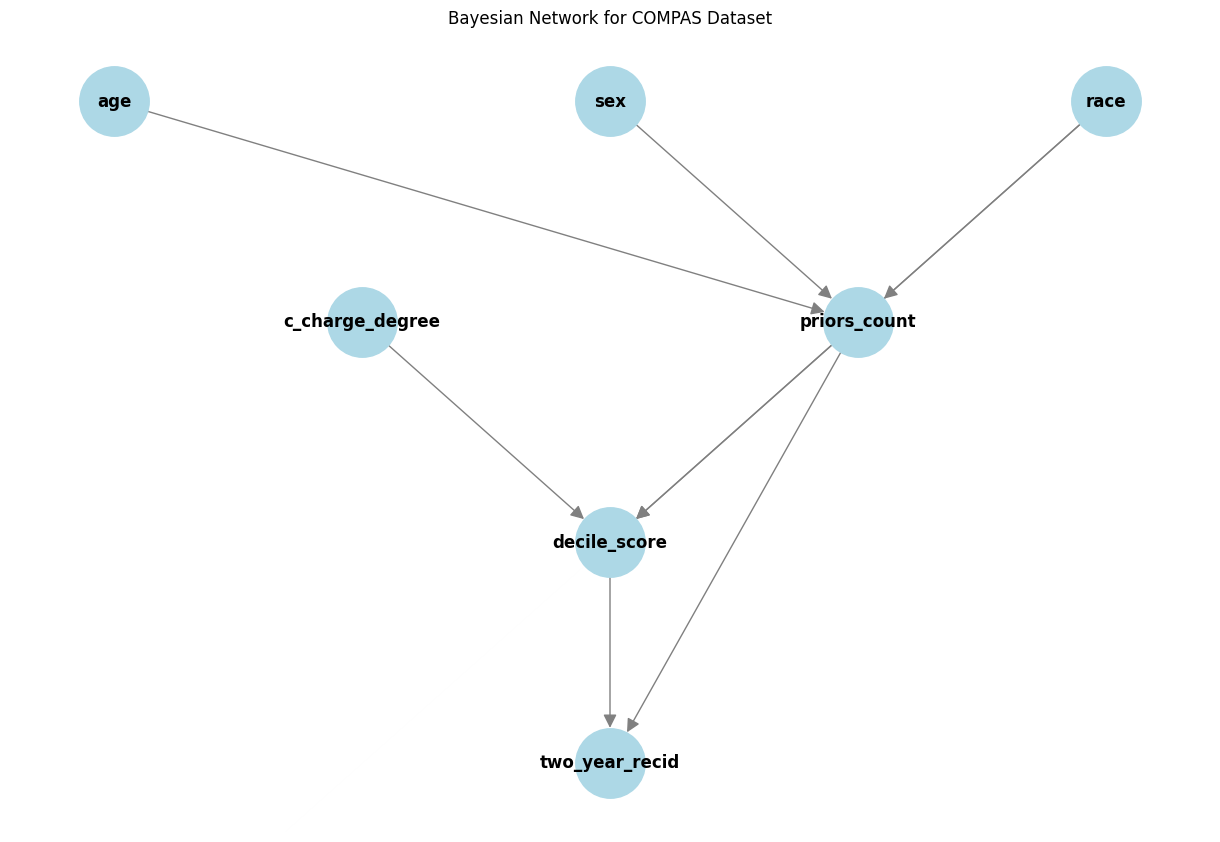

In [7]:
# Convert to networkx graph
G = nx.DiGraph(model.edges())

# Assign layers manually based on dependency depth
layers = {
    'race': 0, 'sex': 0, 'age': 0,  # Root nodes (no incoming edges)
    'priors_count': 1,             # Level 1 (depends on root nodes)
    'c_charge_degree': 1,          # Level 1 (independent input to decile_score)
    'decile_score': 2,             # Level 2 (depends on priors_count and c_charge_degree)
    'two_year_recid': 3            # Level 3 (depends on decile_score and priors_count)
}

# Set the layer attribute for each node
for node in G.nodes():
    G.nodes[node]['layer'] = layers[node]

# Use multipartite layout to position nodes by layer
pos = nx.multipartite_layout(G, subset_key='layer', align='horizontal')

# Adjust y-positions to flip top-down (higher layer = lower y)
max_layer = max(layers.values())
for node in pos:
    pos[node][1] = max_layer - layers[node]  # Invert y-axis

# Draw the network
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2500, font_size=12, font_weight='bold', arrowsize=20, edge_color='gray')
plt.title('Bayesian Network for COMPAS Dataset')
plt.show()

In [8]:
# Prepare data for BN (discretize continuous variables)
df_bn = df_subset.copy()
df_bn['age'] = pd.cut(df_bn['age'], bins=3, labels=['Young', 'Middle', 'Old'])
df_bn['priors_count'] = pd.cut(df_bn['priors_count'], bins=3, labels=['Low', 'Med', 'High'])

# Define the structure without decile_score
model = BayesianNetwork([
    ('race', 'priors_count'), ('sex', 'priors_count'), ('age', 'priors_count'),
    ('priors_count', 'two_year_recid'), ('c_charge_degree', 'two_year_recid')
])

# Fit the model
model.fit(df_bn, estimator=MaximumLikelihoodEstimator)

# Check independencies
print('Conditional Independencies:')
print(model.get_independencies())

# Example inference
infer = VariableElimination(model)
q = infer.query(variables=['two_year_recid'], evidence={'race': 'African-American', 'priors_count': 'High'})
print('P(two_year_recid | race=African-American, priors_count=High):')
print(q)

Conditional Independencies:
(race ⟂ sex, age, c_charge_degree)
(race ⟂ c_charge_degree, sex | age)
(race ⟂ age, sex | c_charge_degree)
(race ⟂ age, c_charge_degree | sex)
(race ⟂ two_year_recid, c_charge_degree | priors_count)
(race ⟂ sex | age, c_charge_degree)
(race ⟂ c_charge_degree | age, sex)
(race ⟂ two_year_recid, c_charge_degree | age, priors_count)
(race ⟂ age | sex, c_charge_degree)
(race ⟂ two_year_recid | priors_count, c_charge_degree)
(race ⟂ two_year_recid, c_charge_degree | priors_count, sex)
(race ⟂ c_charge_degree | two_year_recid, priors_count)
(race ⟂ two_year_recid | priors_count, age, c_charge_degree)
(race ⟂ two_year_recid, c_charge_degree | priors_count, age, sex)
(race ⟂ c_charge_degree | age, two_year_recid, priors_count)
(race ⟂ two_year_recid | sex, priors_count, c_charge_degree)
(race ⟂ c_charge_degree | priors_count, two_year_recid, sex)
(race ⟂ two_year_recid | sex, priors_count, age, c_charge_degree)
(race ⟂ c_charge_degree | priors_count, age, two_year_r

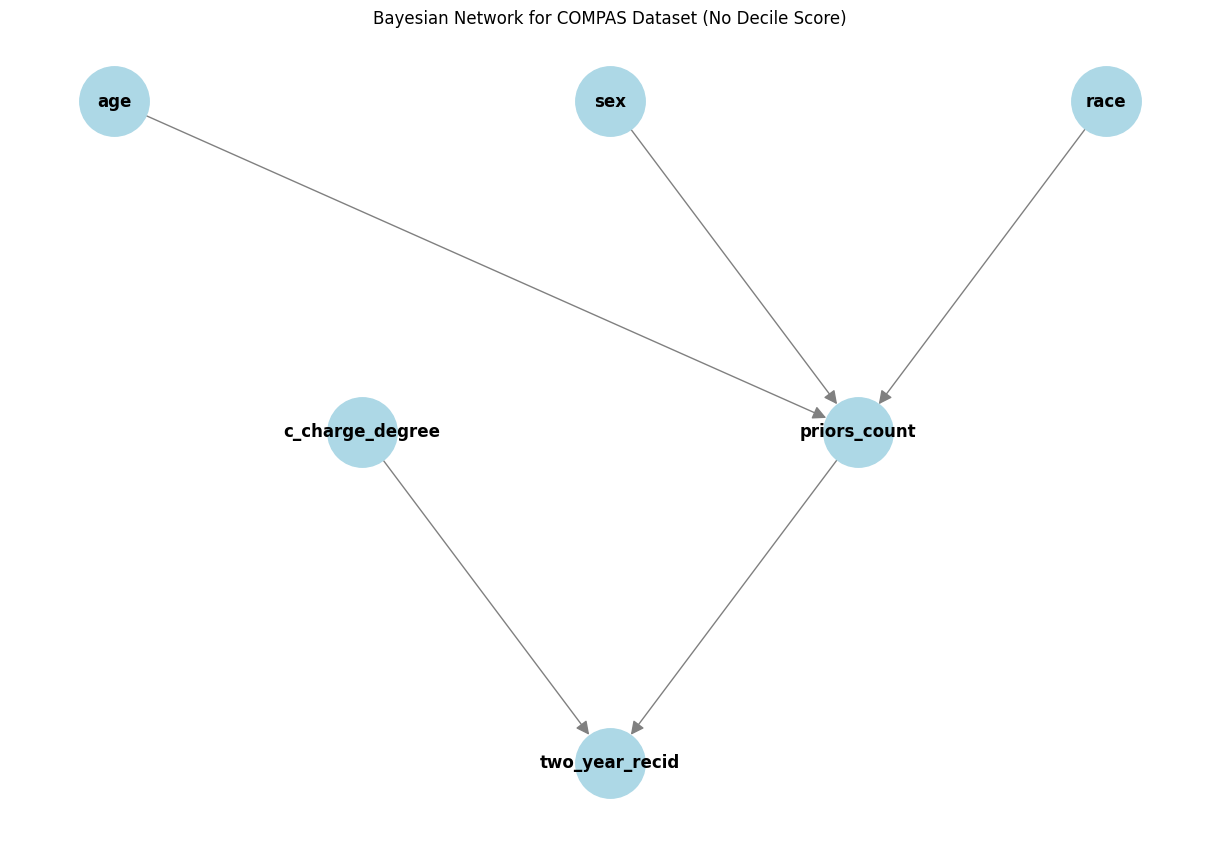

In [9]:
# Convert to networkx graph
G = nx.DiGraph(model.edges())

# Assign layers manually based on dependency depth
layers = {
    'race': 0, 'sex': 0, 'age': 0,  # Root nodes (no incoming edges)
    'priors_count': 1,             # Level 1 (depends on root nodes)
    'c_charge_degree': 1,          # Level 1 (independent input to two_year_recid)
    'two_year_recid': 2            # Level 2 (depends on priors_count and c_charge_degree)
}

# Set the layer attribute for each node
for node in G.nodes():
    G.nodes[node]['layer'] = layers[node]

# Use multipartite layout to position nodes by layer
pos = nx.multipartite_layout(G, subset_key='layer', align='horizontal')

# Adjust y-positions to flip top-down (higher layer = lower y)
max_layer = max(layers.values())
for node in pos:
    pos[node][1] = max_layer - layers[node]  # Invert y-axis

# Draw the network
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2500, font_size=12, font_weight='bold', arrowsize=20, edge_color='gray')
plt.title('Bayesian Network for COMPAS Dataset (No Decile Score)')
plt.show()

## Summary
- **Statistical Independence**: `race` and `sex` are nearly independent (p ~0.10), while `sex` and `c_charge_degree` are dependent (p < 0.05).
- **Conditional Independence**: `race` ⊥ `two_year_recid` | `priors_count` in some bins; `sex` ⊥ `decile_score` | `c_charge_degree` (MI drops).
- **Bayesian Network**: Models demographics → priors → score → recidivism, with a `race` → `decile_score` edge for bias. The visualization confirms the structure.
### Next Steps
- Refine the BN with more variables (e.g., `juv_fel_count`) or continuous nodes.
- Validate independencies with larger tests or bootstrap methods.